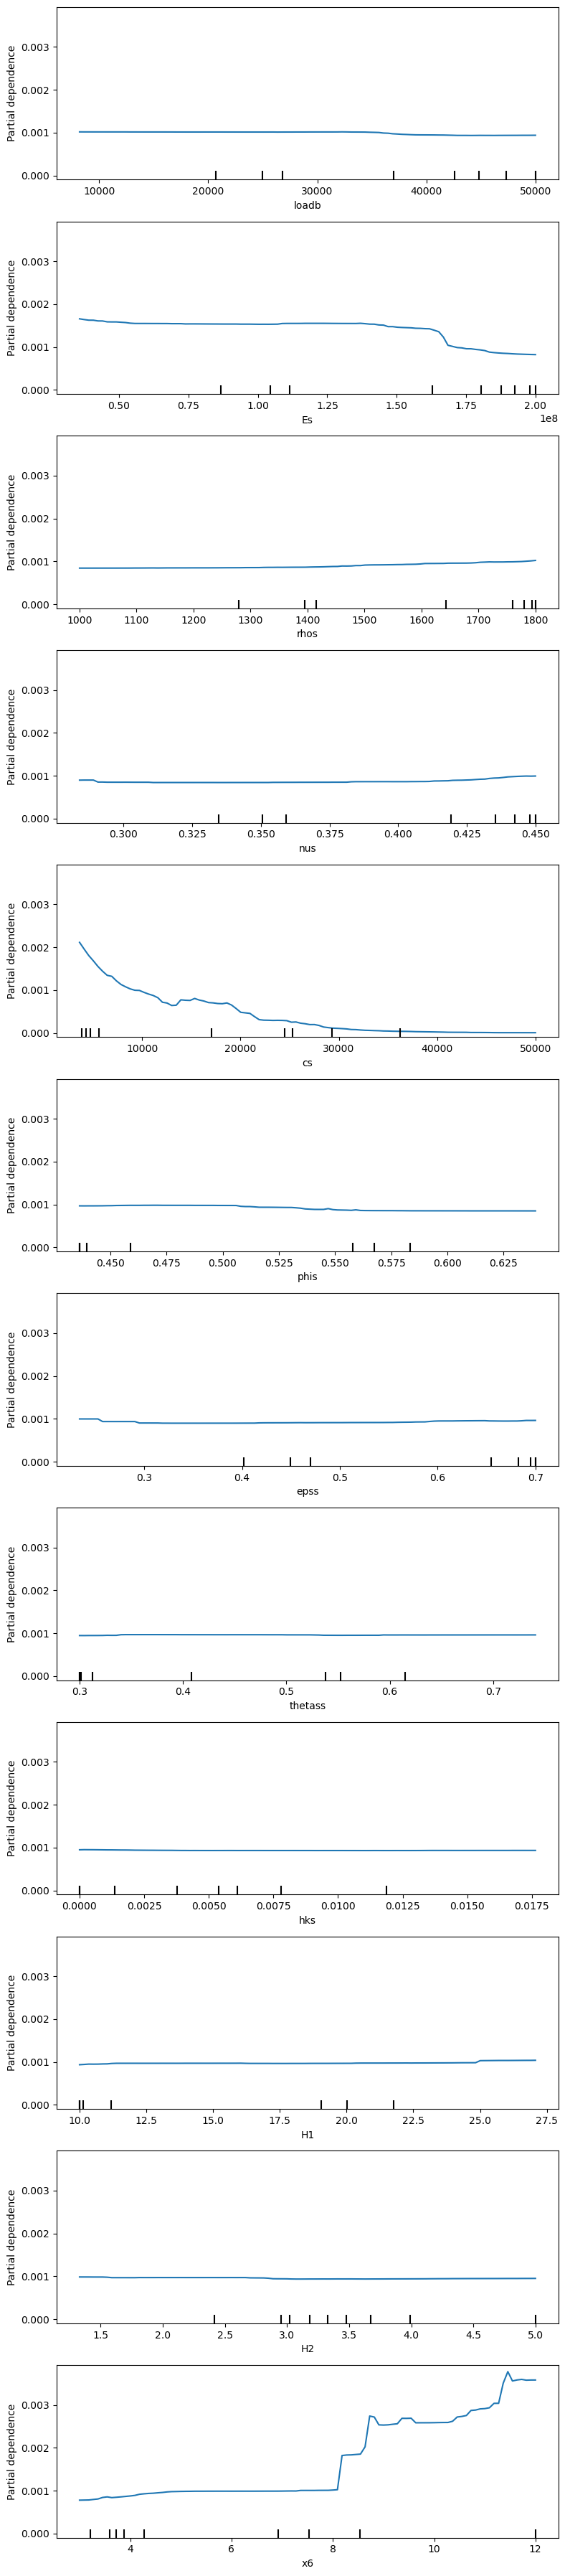

In [2]:
# ---------------------------PDP Analysis -------------------
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# === CONFIG ===
# Load files (multiple files), update path as needed
DB_PATHS = [
    "/Users/......./pso_r_7.db",
    "/Users/......./pso_Qgauss_2.db",
    "/Users/......./pso_Qcauchy_1.db",
    "/Users/......./pso_QLevyII_1.db"
]
PARAM_COLS = ["loadb", "Es", "rhos", "nus", "cs", "phis",
              "epss", "thetass", "hks", "H1", "H2", "x6"]
PDP_PARAMS_1D = ["loadb", "Es", "rhos", "nus", "cs", "phis",
              "epss", "thetass", "hks", "H1", "H2", "x6"]  # modify as needed
PDP_OUTPUT = "pdp_1D_plot.png"

# === LOAD DATA ===
all_data = []
for path in DB_PATHS:
    try:
        conn = sqlite3.connect(path)
        df_part = pd.read_sql_query(f"SELECT {', '.join(PARAM_COLS)}, e_plst FROM particles", conn)
        all_data.append(df_part)
        conn.close()
    except Exception as e:
        print(f"⚠️ Failed to load from {path}: {e}")

df = pd.concat(all_data, ignore_index=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["e_plst"], inplace=True)

# === FIT RANDOM FOREST
X = df[PARAM_COLS]
y = df["e_plst"]
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# === PLOT PDP
fig, ax = plt.subplots(len(PDP_PARAMS_1D), figsize=(8, 3 * len(PDP_PARAMS_1D)))
PartialDependenceDisplay.from_estimator(rf, X, PDP_PARAMS_1D, ax=ax)
# plt.suptitle("Partial Dependence Plots (1D)")
plt.tight_layout()
plt.savefig(PDP_OUTPUT)
plt.show()


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
from itertools import combinations

from scipy.stats import entropy
from numpy.linalg import matrix_rank

# === CONFIG ===
DB_PATHS = [
    "/Users/......./pso_r_7_iter1_300.db",
    "/Users/......./pso_Qgauss_2.db",
    "/Users/......./pso_Qcauchy_1.db",
    "/Users/......./pso_QLevyII_1.db"
]
PARAM_COLS = ["loadb", "Es", "rhos", "nus", "cs", "phis",
              "epss", "thetass", "hks", "H1", "H2", "x6"]
N_BINS = 5
OUTPUT_CSV = "s2_estimates_quantile.csv"

# === LOAD + MERGE DATA ===
all_data = []
for path in DB_PATHS:
    try:
        conn = sqlite3.connect(path)
        df_part = pd.read_sql_query(f"SELECT {', '.join(PARAM_COLS)}, ppi FROM particles", conn)
        all_data.append(df_part)
        conn.close()
    except Exception as e:
        print(f"⚠️ Failed to load from {path}: {e}")

df = pd.concat(all_data, ignore_index=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["ppi"], inplace=True)
df_clean = df.copy()

# === GLOBAL VARIANCE ===
total_var_ppi = np.var(df_clean["ppi"].values)
print(f"Total Variance in PPI: {total_var_ppi:.6f}")

# === S2 CALCULATION ===
s2_results = []
for i, j in combinations(PARAM_COLS, 2):
    try:
        df_clean["bin_i"] = pd.qcut(df_clean[i], q=N_BINS, duplicates="drop")
        df_clean["bin_j"] = pd.qcut(df_clean[j], q=N_BINS, duplicates="drop")

        mean_ppi_grid = (
            df_clean.groupby(["bin_i", "bin_j"], observed=True)["ppi"]
            .mean()
            .unstack(fill_value=np.nan)
            .values
        )

        # Flatten and clean for variance calculation
        mean_ppi_flat = mean_ppi_grid.flatten()
        mean_ppi_flat = mean_ppi_flat[~np.isnan(mean_ppi_flat)]

        s2_value = np.var(mean_ppi_flat) / total_var_ppi
        s2_results.append({
            "Parameter 1": i,
            "Parameter 2": j,
            "S2 Estimate": s2_value
        })
    except Exception as e:
        print(f"⚠️ Skipped {i}-{j}: {e}")
        continue

# === OUTPUT ===
df_s2 = pd.DataFrame(s2_results).sort_values(by="S2 Estimate", ascending=False)
df_s2.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ S2 estimation complete. Results saved to: {OUTPUT_CSV}")
print(df_s2.head(10))


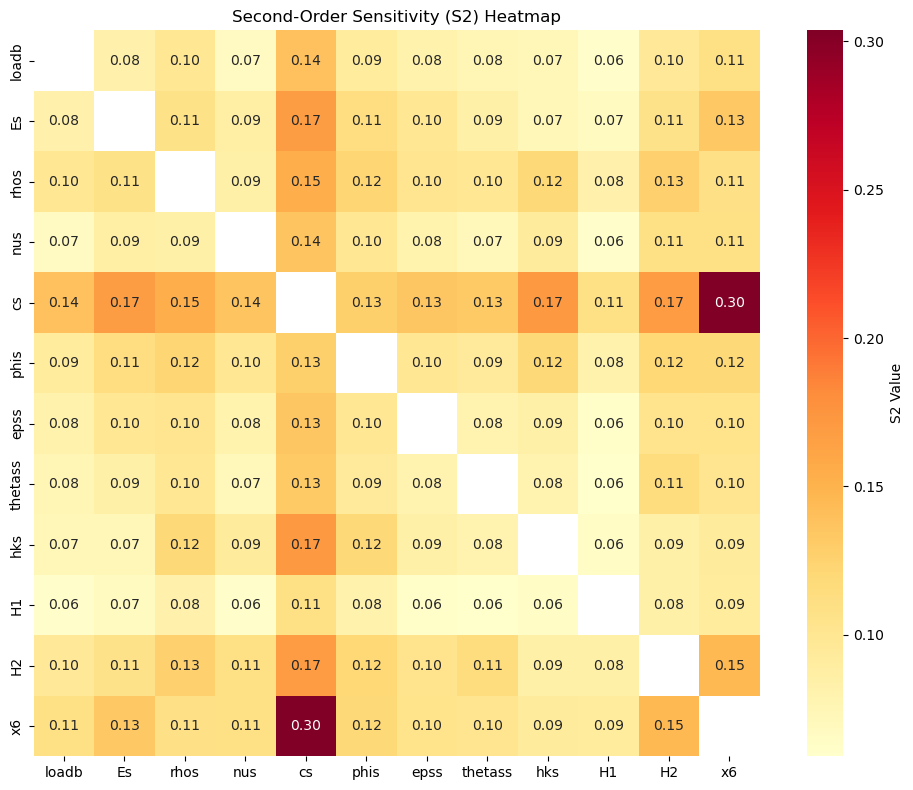


✅ Saved top 15 S2 interactions to: s2_top_interactions.csv


In [4]:
# -----------------------S2 Sensitivity -------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# === CONFIG ===
S2_FILE = "s2_estimates_quantile.csv"
PARAM_COLS = ["loadb", "Es", "rhos", "nus", "cs", "phis",
              "epss", "thetass", "hks", "H1", "H2", "x6"]
HEATMAP_FILE = "s2_interaction_heatmap.png"
TOP_CSV = "s2_top_interactions.csv"
TOP_N = 15  # how many top pairs to save

# === LOAD DATA ===
df_s2 = pd.read_csv(S2_FILE)

# === CREATE FULL S2 MATRIX ===
s2_matrix = pd.DataFrame(index=PARAM_COLS, columns=PARAM_COLS, data=np.nan)
for _, row in df_s2.iterrows():
    i, j = row["Parameter 1"], row["Parameter 2"]
    s2_matrix.loc[i, j] = row["S2 Estimate"]
    s2_matrix.loc[j, i] = row["S2 Estimate"]  # make symmetric

# === PLOT HEATMAP ===
plt.figure(figsize=(10, 8))
sns.heatmap(s2_matrix, cmap="YlOrRd", annot=True, fmt=".2f", square=True, cbar_kws={'label': 'S2 Value'})
plt.title("Second-Order Sensitivity (S2) Heatmap")
plt.tight_layout()
plt.savefig(HEATMAP_FILE)
plt.show()

# === TOP RANKED INTERACTIONS ===
df_top = df_s2.sort_values(by="S2 Estimate", ascending=False).head(TOP_N)
df_top.to_csv(TOP_CSV, index=False)
print(f"\n✅ Saved top {TOP_N} S2 interactions to: {TOP_CSV}")
